<div style="text-align: right"> CS824 - Lab 3b (2022) </div>

# Practical Intro to Probability (Part 2)


What you will find below are some additional elements taken from Norwig's excellent tutorial, which brings up a few more examples of how to use the 'countability' approach to probability.

The first section shows how we can use these approaches to explore a little 'historical wager' between **Pierre de Fermat** and **Blaise Pascal**. 

There is then a section on **non-equally probable outcomes** and how we need to adjust our approach to incorporate probability distributions (there will be more on this in future weeks).

Finally there is a nice little 'probabilistic simulation' of the board game *Monopoly*...  similar to what is implemented and discussed in one of this week's Additional Resources videos noted on MyPlace.


In [1]:
# Libraries and functions that we used in Part_1 of the lab and will be needed here...

import itertools
from fractions import Fraction

def P(event, sample_space): 
    """The probability of an event, given a sample space of equiprobable outcomes.
    The event can be either a set of outcomes, or a predicate (true for outcomes in the event)."""
    if is_predicate(event):
        event = such_that(event, sample_space)
    return Fraction(len(event & sample_space), len(sample_space))

is_predicate = callable

def such_that(predicate, collection): 
    "The subset of elements in the collection for which the predicate is true."
    return {e for e in collection if predicate(e)}

def joint(A, B, sep=''):
    """The joint distribution of two independent probability distributions. 
    Result is all entries of the form {a+sep+b: P(a)*P(b)}"""
    return ProbDist({a + sep + b: A[a] * B[b]
                    for a in A
                    for b in B})


# 1. Fermat and Pascal: Gambling, Triangles, and the Birth of Probability

<table>
<tr><td><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/98/Pierre_de_Fermat2.png/140px-Pierre_de_Fermat2.png"><center><a href="https://en.wikipedia.org/wiki/Pierre_de_Fermat">Pierre de Fermat</a><br>1654
<td><img src="https://www.umass.edu/wsp/images/pascal.jpg"><center><a href="https://en.wikipedia.org/wiki/Blaise_Pascal">Blaise Pascal]</a><br>1654
</table>

Consider a gambling game consisting of tossing a coin. Player H wins the game if 10 heads come up, and T wins if 10 tails come up. If the game is interrupted when H has 8 heads and T has 7 tails, how should the pot of money (which happens to be 100 Francs) be split?
In 1654, Blaise Pascal and Pierre de Fermat corresponded on this problem, with Fermat [writing](http://mathforum.org/isaac/problems/prob1.html):

>Dearest Blaise,

>As to the problem of how to divide the 100 Francs, I think I have found a solution that you will find to be fair. Seeing as I needed only two points to win the game, and you needed 3, I think we can establish that after four more tosses of the coin, the game would have been over. For, in those four tosses, if you did not get the necessary 3 points for your victory, this would imply that I had in fact gained the necessary 2 points for my victory. In a similar manner, if I had not achieved the necessary 2 points for my victory, this would imply that you had in fact achieved at least 3 points and had therefore won the game. Thus, I believe the following list of possible endings to the game is exhaustive. I have denoted 'heads' by an 'h', and tails by a 't.' I have starred the outcomes that indicate a win for myself.

    h h h h *       h h h t *       h h t h *       h h t t *
    h t h h *       h t h t *       h t t h *       h t t t
    t h h h *       t h h t *       t h t h *       t h t t
    t t h h *       t t h t         t t t h         t t t t

>I think you will agree that all of these outcomes are equally likely. Thus I believe that we should divide the stakes by the ration 11:5 in my favor, that is, I should receive (11/16)*100 = 68.75 Francs, while you should receive 31.25 Francs.

>I hope all is well in Paris,

>Your friend and colleague,

>Pierre

Pascal agreed with this solution, and [replied](http://mathforum.org/isaac/problems/prob2.html) with a generalization that made use of his previous invention, Pascal's Triangle. There's even [a book](https://smile.amazon.com/Unfinished-Game-Pascal-Fermat-Seventeenth-Century/dp/0465018963?sa-no-redirect=1) about it.

We can solve the problem with the tools we have:

In [6]:
def win_unfinished_game(Hneeds, Tneeds):
    "The probability that H will win the unfinished game, given the number of points needed by H and T to win."
    def Hwins(outcome): return outcome.count('h') >= Hneeds
    return P(Hwins, continuations(Hneeds, Tneeds))

def continuations(Hneeds, Tneeds):
    "All continuations of a game where H needs `Hneeds` points to win and T needs `Tneeds`."
    rounds = ['ht' for _ in range(Hneeds + Tneeds - 1)]
    return set(itertools.product(*rounds))

In [5]:
continuations(2, 3)

['ht', 'ht', 'ht', 'ht']


{('h', 'h', 'h', 'h'),
 ('h', 'h', 'h', 't'),
 ('h', 'h', 't', 'h'),
 ('h', 'h', 't', 't'),
 ('h', 't', 'h', 'h'),
 ('h', 't', 'h', 't'),
 ('h', 't', 't', 'h'),
 ('h', 't', 't', 't'),
 ('t', 'h', 'h', 'h'),
 ('t', 'h', 'h', 't'),
 ('t', 'h', 't', 'h'),
 ('t', 'h', 't', 't'),
 ('t', 't', 'h', 'h'),
 ('t', 't', 'h', 't'),
 ('t', 't', 't', 'h'),
 ('t', 't', 't', 't')}

In [7]:
win_unfinished_game(2, 3)

Fraction(11, 16)

Our answer agrees with Pascal and Fermat; so we are in good company!

# 2. Outcomes that are not equally likely: Probability Distributions

So far, we have made the assumption that every outcome in a sample space is equally likely. In real life, we often get outcomes that are not equiprobable. For example, the probability of a child being a girl is not exactly 1/2, and the probability is slightly different for a second child. An [article](http://people.kzoo.edu/barth/math105/moreboys.pdf) gives the following counts for two-child families in Denmark, where `GB` means a family where the first child is a girl and the second a boy:

    GG: 121,801    GB: 126,840
    BG: 127,123    BB: 135,138
    
We will introduce three more definitions:

* [Frequency](https://en.wikipedia.org/wiki/Frequency_%28statistics%29): a number describing how often an outcome occurs. Can be a count like 121,801 or a ratio like 0.515.

* [Distribution](http://mathworld.wolfram.com/StatisticalDistribution.html): A mapping from outcome to frequency for each outcome in a sample space. 

* [Probability Distribution](https://en.wikipedia.org/wiki/Probability_distribution): A distribution that has been *normalized* so that the sum of the frequencies is 1.

We define `ProbDist` to take the same kinds of arguments that `dict` does: either a mapping or an iterable of `(key, val)` pairs, and/or optional keyword arguments. 

**(For those of you new to Python, please feel free to skim over much of the detail. For example, you have likely not encountered dictionaries. Hopefully the general approach will still make sense, even if you feel unable to follow the detail.)**

In [8]:
class ProbDist(dict):
    "A Probability Distribution; an {outcome: probability} mapping."
    def __init__(self, mapping=(), **kwargs):
        self.update(mapping, **kwargs)
        # Make probabilities sum to 1.0; assert no negative probabilities
        total = sum(self.values())
        for outcome in self:
            self[outcome] = self[outcome] / total
            assert self[outcome] >= 0

We also need to modify the functions `P` and `such_that` to accept either a sample space  or a probability distribution as the second argument.

In [9]:
def P(event, space): 
    """The probability of an event, given a sample space of equiprobable outcomes. 
    event: a collection of outcomes, or a predicate that is true of outcomes in the event. 
    space: a set of outcomes or a probability distribution of {outcome: frequency} pairs."""
    if is_predicate(event):
        event = such_that(event, space)
    if isinstance(space, ProbDist):
        return sum(space[o] for o in space if o in event)
    else:
        return Fraction(len(event & space), len(space))
    
def such_that(predicate, space): 
    """The outcomes in the sample pace for which the predicate is true.
    If space is a set, return a subset {outcome,...};
    if space is a ProbDist, return a ProbDist {outcome: frequency,...};
    in both cases only with outcomes where predicate(element) is true."""
    if isinstance(space, ProbDist):
        return ProbDist({o:space[o] for o in space if predicate(o)})
    else:
        return {o for o in space if predicate(o)}

Here is the probability distribution for Danish two-child families:

In [10]:
DK = ProbDist(GG=121801, GB=126840,
              BG=127123, BB=135138)
DK

{'GG': 0.23840384261560926,
 'GB': 0.24826679089140383,
 'BG': 0.24882071317004043,
 'BB': 0.2645086533229465}

And here are some predicates that will allow us to answer some questions:

In [12]:
def first_girl(outcome):  return outcome[0] == 'G'
def first_boy(outcome):   return outcome[0] == 'B'
def second_girl(outcome): return outcome[1] == 'G'
def second_boy(outcome):  return outcome[1] == 'B'
def two_girls(outcome):   return outcome    == 'GG'
def two_boys(outcome):    return outcome    == 'BB'

In [13]:
P(first_girl, DK)

0.4866706335070131

In [14]:
P(second_girl, DK)

0.4872245557856497

The above says that the probability of a girl is somewhere between 48% and 49%, but that it is slightly different between the first or second child.

In [15]:
P(second_girl, such_that(first_girl, DK)), P(second_girl, such_that(first_boy, DK))

(0.4898669165584115, 0.48471942072973107)

In [16]:
P(second_girl, such_that(first_girl, DK)) - P(second_girl, such_that(first_boy, DK))

0.0051474958286804595

In [17]:
P(second_boy, such_that(first_boy, DK)), P(second_boy, such_that(first_girl, DK))

(0.5152805792702689, 0.5101330834415885)

In [18]:
P(second_boy, such_that(first_boy, DK)) - P(second_boy, such_that(first_girl, DK))

0.0051474958286804595

The above says that the sex of the second child is more likely to be the same as the first child, by just over 1/2 a percentage point.

# 2. (cont) Newton's Answer to a Problem by Pepys

Samuel Pepys wrote to Isaac Newton in 1693 to pose the problem:

> Which of the following three propositions has the greatest chance of success? 
  1. Six fair dice are tossed independently and at least one “6” appears. 
  2. Twelve fair dice are tossed independently and at least two “6”s appear. 
  3. Eighteen fair dice are tossed independently and at least three “6”s appear.
  
Newton was able to answer the question correctly (although his reasoning was not quite right); let's see how we can do. 

Since we're only interested in whether a die comes up as "6" or not, we can define a single die and the joint distribution over *n* dice as follows:

In [19]:
die = ProbDist({'6':1/6, '-':5/6})

def dice(n, die):
    "Joint probability from tossing n dice."
    if n == 1:
        return die
    else:
        return joint(die, dice(n - 1, die))

In [23]:
dice(6, die)

{'666666': 2.1433470507544573e-05,
 '66666-': 0.00010716735253772288,
 '6666-6': 0.00010716735253772288,
 '6666--': 0.0005358367626886143,
 '666-66': 0.00010716735253772288,
 '666-6-': 0.0005358367626886143,
 '666--6': 0.0005358367626886143,
 '666---': 0.0026791838134430724,
 '66-666': 0.00010716735253772289,
 '66-66-': 0.0005358367626886143,
 '66-6-6': 0.0005358367626886143,
 '66-6--': 0.0026791838134430724,
 '66--66': 0.0005358367626886143,
 '66--6-': 0.0026791838134430724,
 '66---6': 0.0026791838134430724,
 '66----': 0.013395919067215364,
 '6-6666': 0.00010716735253772288,
 '6-666-': 0.0005358367626886143,
 '6-66-6': 0.0005358367626886143,
 '6-66--': 0.002679183813443072,
 '6-6-66': 0.0005358367626886143,
 '6-6-6-': 0.002679183813443072,
 '6-6--6': 0.002679183813443072,
 '6-6---': 0.013395919067215364,
 '6--666': 0.0005358367626886145,
 '6--66-': 0.002679183813443072,
 '6--6-6': 0.002679183813443072,
 '6--6--': 0.013395919067215364,
 '6---66': 0.002679183813443072,
 '6---6-': 0.0133

In [20]:
dice(3, die)

{'666': 0.0046296296296296285,
 '66-': 0.023148148148148143,
 '6-6': 0.023148148148148143,
 '6--': 0.11574074074074073,
 '-66': 0.023148148148148143,
 '-6-': 0.11574074074074073,
 '--6': 0.11574074074074073,
 '---': 0.5787037037037037}

Now we are ready to determine which proposition is more likely to have the required number of sixes:

In [21]:
def at_least(k, result): return lambda s: s.count(result) >= k

In [22]:
P(at_least(1, '6'), dice(6, die))

0.6651020233196159

In [24]:
P(at_least(2, '6'), dice(12, die))

0.6186673737323101

In [25]:
P(at_least(3, '6'), dice(18, die))

0.5973456859477544

We reach the same conclusion Newton did, that the best chance is when you **only roll six** dice...

<hr>

# 3. Simulation

Sometimes it is inconvenient to explicitly define a sample space. Perhaps the sample space is infinite, or perhaps it is just very large and complicated, and we feel more confident in writing a program to *simulate* one pass through all the complications, rather than try to *enumerate* the complete sample space. *Random sampling* from the simulation
can give an accurate estimate of the probability.

# Simulating Monopoly

![](http://buckwolf.org/a.abcnews.com/images/Entertainment/ho_hop_go_050111_t.jpg)<center>[Mr. Monopoly](https://en.wikipedia.org/wiki/Rich_Uncle_Pennybags)<br>1940&mdash;

Consider [problem 84](https://projecteuler.net/problem=84) from the excellent [Project Euler](https://projecteuler.net), which asks for the probability that a player in the game Monopoly ends a roll on each of the squares on the board.  To answer this we need to take into account die rolls, chance and community chest cards, and going to jail (from the "go to jail" space, from a card, or from rolling doubles three times in a row). We do not need to take into account anything about buying or selling properties or exchanging money or winning or losing the game, because these don't change a player's location. We will assume that a player in jail will always pay to get out of jail immediately. 

A game of Monopoly can go on forever, so the sample space is infinite. But even if we limit the sample space to say, 1000 rolls, there are $21^{1000}$ such sequences of rolls (and even more possibilities when we consider drawing cards). So it is infeasible to explicitly represent the sample space.

But it is fairly straightforward to implement a simulation and run it for, say, 400,000 rolls (so the average square will be landed on 10,000 times).  Here is the code for a simulation:

In [26]:
from collections import Counter, deque
import random

# The board: a list of the names of the 40 squares
# As specified by https://projecteuler.net/problem=84
board = """GO   A1 CC1 A2  T1 R1 B1  CH1 B2 B3
           JAIL C1 U1  C2  C3 R2 D1  CC2 D2 D3 
           FP   E1 CH2 E2  E3 R3 F1  F2  U2 F3 
           G2J  G1 G2  CC3 G3 R4 CH3 H1  T2 H2""".split()

def monopoly(steps):
    """Simulate given number of steps of Monopoly game, 
    yielding the number of the current square after each step."""
    goto(0) # start at GO
    CC_deck = Deck('GO JAIL' + 14 * ' ?')
    CH_deck = Deck('GO JAIL C1 E3 H2 R1 R R U -3' + 6 * ' ?')
    doubles = 0
    jail = board.index('JAIL')
    for _ in range(steps):
        d1, d2 = random.randint(1, 6), random.randint(1, 6)
        goto(here + d1 + d2)
        doubles = (doubles + 1) if (d1 == d2) else 0
        if doubles == 3 or board[here] == 'G2J':  
            goto(jail)
        elif board[here].startswith('CC'):
            do_card(CC_deck)
        elif board[here].startswith('CH'):
            do_card(CH_deck)
        yield here         

def goto(square):
    "Update the global variable 'here' to be square."
    global here
    here = square % len(board)
                   
def Deck(names):
    "Make a shuffled deck of cards, given a space-delimited string."
    cards = names.split()
    random.shuffle(cards)
    return deque(cards)         

def do_card(deck):
    "Take the top card from deck and do what it says."
    global here
    card = deck[0]             # The top card
    deck.rotate(-1)            # Move top card to bottom of deck
    if card == 'R' or card == 'U': 
        while not board[here].startswith(card):
            goto(here + 1)     # Advance to next railroad or utility
    elif card == '-3':
        goto(here - 3)         # Go back 3 spaces
    elif card != '?':
        goto(board.index(card))# Go to destination named on card

And the results:

In [27]:
results = list(monopoly(400000))

I'll show a histogram of the squares, with a dotted red line at the average:

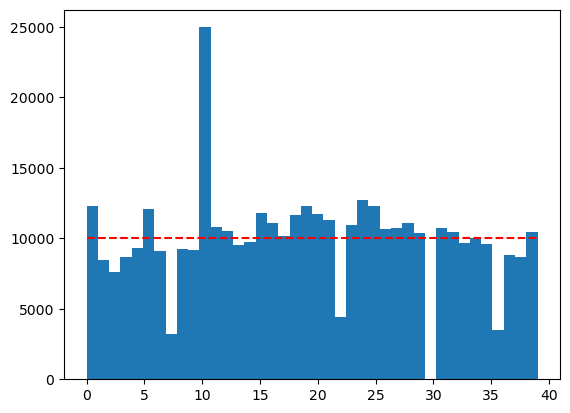

In [28]:
%matplotlib inline 
import matplotlib.pyplot as plt

plt.hist(results, bins=40)
avg = len(results) / 40
plt.plot([0, 39], [avg, avg], 'r--');

Another way to see the results:

In [29]:
ProbDist(Counter(board[i] for i in results))

{'B3': 0.02294,
 'D1': 0.02768,
 'F2': 0.026795,
 'JAIL': 0.062435,
 'D2': 0.0291025,
 'E2': 0.0274325,
 'F1': 0.0266575,
 'CC3': 0.0241325,
 'A1': 0.0212125,
 'B2': 0.0231775,
 'C1': 0.0269875,
 'C3': 0.024405,
 'E1': 0.0281825,
 'G2': 0.0260975,
 'H2': 0.026115,
 'CC1': 0.01901,
 'U1': 0.02625,
 'E3': 0.0318375,
 'G1': 0.026785,
 'R4': 0.0240525,
 'GO': 0.03073,
 'T1': 0.023355,
 'CC2': 0.025425,
 'R3': 0.0307725,
 'H1': 0.02198,
 'C2': 0.0238825,
 'FP': 0.0293125,
 'F3': 0.0259925,
 'R1': 0.0302125,
 'U2': 0.0276975,
 'CH3': 0.0088075,
 'CH2': 0.0109625,
 'A2': 0.021705,
 'B1': 0.0227375,
 'R2': 0.0295175,
 'G3': 0.0250025,
 'D3': 0.0308,
 'T2': 0.0217525,
 'CH1': 0.0080675}

Remember that this is a *stochastic* simualation (involves randomness) and that as such the numbers each of us see will be slightly different. However, the over all 'shape' should be the same, which is why the histogram may be a more useful summary than the detailed values.

You will see that one square is landed on far above average: `JAIL`, at a little over 6% of the time. There are four squares far below average: the three chance squares, `CH1`, `CH2`, and `CH3`, at around 1% (because 10 of the 16 chance cards send the player away from the square), and the "Go to Jail" square, with x value of `30` on the histogram, which has a frequency of 0 because you can't end a turn there. The other squares are around 2% to 3% each, which you would expect, because 1 / 40 (number of squares) = 0.025

Real  aficionados of *Monopoly* may be interested in a few other (more subtle) outcomes.  For those who have never played if you are really interested you can check out the various sets of [locations](https://en.wikipedia.org/wiki/List_of_London_Monopoly_locations).

Many of us who played as kids can remember that the `orange` set {Bow St, Marlborough St, Vine St} was a favourite, and sure enough, these have among the highest probabilities of the 'normal' squares to be landed on (they are {D1}-{D3} here). Though interestingly the `red` set {Strand, Fleet St, Trafalgar Sq} actually have better odds of being landed on...  but they are more expensive to develop - which is where the strategy and decision-making part of the game interacts with the absolute probabilities of landing on different sqaures.

Interesting this shows up something that I don't think I ever realised while playing. The railway stations are in general quite 'productive', but Liverpool St Station (here {R4}) is significantly less likely (at a value of < 0.025) to be landed on than the other three stations (which all have values of ~0.03)...   

However, I had better stop there before I get too carried away!!



Almost all of **Lab_3b** has been taken from Peter's excellent tutorial on *Probability and Paradox* - which you are free to explore on your own as time allows.
